#### Tweak 4.2 — Augmentation + Longer Training + OneCycleLR

#### 1.1 Environment Check

In [206]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

In [207]:
from torch.optim.lr_scheduler import OneCycleLR

In [208]:
# reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# device selection: CUDA > MPS > CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f'PyTorch version : {torch.__version__}')
print(f'Device          : {device}')
if device.type == 'cuda':
    print(f'GPU             : {torch.cuda.get_device_name(0)}')

PyTorch version : 2.9.0+cu128
Device          : cuda
GPU             : Tesla T4


#### 1.2 The Subset (with Augmentation)

In [209]:
# standard normalization
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

def get_cifar10_subsets(train_transform, n_train=5000, n_test=1000, batch_size=64, num_workers=2):

    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
    ])

    full_train = torchvision.datasets.CIFAR10(
        root='../data', train=True, download=True, transform=train_transform)
    full_test = torchvision.datasets.CIFAR10(
        root='../data', train=False, download=True, transform=val_transform)

    train_subset = Subset(full_train, range(n_train))
    test_subset  = Subset(full_test,  range(n_test))

    train_loader = DataLoader(train_subset, batch_size=batch_size,
                              shuffle=True, num_workers=num_workers)
    val_loader   = DataLoader(test_subset,  batch_size=batch_size,
                              shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, full_train.classes

In [210]:
# Training transform: Bag of Tricks augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
])

print('Training Transform (Bag of Tricks):')
print(train_transform)

Training Transform (Bag of Tricks):
Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    RandomCrop(size=(32, 32), padding=4)
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
)


In [211]:
train_loader, val_loader, classes = get_cifar10_subsets(train_transform)

print(f'Training samples   : {len(train_loader.dataset)}')
print(f'Validation samples : {len(val_loader.dataset)}')
print(f'Classes            : {classes}')
print(f'Batch size         : {train_loader.batch_size}')

# quick sanity peek
imgs, labels = next(iter(train_loader))
print(f'Batch shape        : {imgs.shape}')  # [64, 3, 32, 32]

Training samples   : 5000
Validation samples : 1000
Classes            : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Batch size         : 64
Batch shape        : torch.Size([64, 3, 32, 32])


### 1.3 The Evaluation Suite

In [212]:
def count_parameters(model):
    """Return total number of trainable parameters."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [213]:
@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    """Compute average loss and accuracy on a dataloader."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

In [214]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                device, epochs=15, scheduler=None):
    """
    Standard training loop. Returns history dict with per-epoch metrics.
    Optionally steps a scheduler each batch if provided.
    """
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [],   'val_acc': []
    }
    best_val_acc = 0.0
    best_weights = None

    for epoch in range(1, epochs + 1):
        # --- train ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc  = 100.0 * correct / total

        # --- validate ---
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        # record
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # checkpoint best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch:3d}/{epochs}  |  '
              f'Train Loss: {train_loss:.4f}  Acc: {train_acc:.2f}%  |  '
              f'Val Loss: {val_loss:.4f}  Acc: {val_acc:.2f}%')

    # restore best weights
    if best_weights:
        model.load_state_dict(best_weights)
    print(f'\nBest validation accuracy: {best_val_acc:.2f}%')
    return history

In [215]:
def plot_history(history, title='Training History'):
    """Plot loss and accuracy curves side by side."""
    epochs = range(1, len(history['train_loss']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # --- loss ---
    ax1.plot(epochs, history['train_loss'], 'o-', label='Train Loss')
    ax1.plot(epochs, history['val_loss'],   's-', label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} \u2014 Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- accuracy ---
    ax2.plot(epochs, history['train_acc'], 'o-', label='Train Acc')
    ax2.plot(epochs, history['val_acc'],   's-', label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{title} \u2014 Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

#### 2.1 Build Model 4.2 — Wider Filters + Dropout + Augmentation + OneCycleLR

Same architecture as 4.1 (= 3.2). The changes are in training:
- **50 epochs** instead of 15
- **OneCycleLR** scheduler with max_lr=0.01

In [216]:
class DeepCNN_WiderFilters(nn.Module):
    """
    Wider Filters + Dropout architecture (from Model 3.2).

    Architecture:
        Block 1: (Conv2d(3->64, 3x3) -> BatchNorm -> ReLU) x 2 -> MaxPool(2) -> Dropout2d(0.1)
        Block 2: (Conv2d(64->128, 3x3) -> BatchNorm -> ReLU) x 2 -> MaxPool(2) -> Dropout2d(0.1)
        Block 3: (Conv2d(128->256, 3x3) -> BatchNorm -> ReLU) x 2 -> MaxPool(2) -> Dropout2d(0.1)
        AdaptiveAvgPool2d(1)  (GAP)
        Flatten -> Dropout(0.5) -> FC(256 -> 10)
    """

    def __init__(self):
        super().__init__()

        # Block 1: 3 -> 64 channels
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1)
        )

        # Block 2: 64 -> 128 channels
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1)
        )

        # Block 3: 128 -> 256 channels
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1)
        )

        # Global Average Pooling + Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x

In [217]:
model = DeepCNN_WiderFilters().to(device)
print(model)
print(f'\nTrainable parameters: {count_parameters(model):,}')

DeepCNN_WiderFilters(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

### 2.2 Train for 50 Epochs (with OneCycleLR)

In [218]:
EPOCHS = 50
MAX_LR = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # start low, OneCycleLR controls LR

steps_per_epoch = len(train_loader)
scheduler = OneCycleLR(optimizer, max_lr=MAX_LR,
                       steps_per_epoch=steps_per_epoch,
                       epochs=EPOCHS)

print(f'Optimizer    : Adam + OneCycleLR (max_lr={MAX_LR})')
print(f'Loss fn      : CrossEntropyLoss')
print(f'Epochs       : {EPOCHS}')
print(f'Device       : {device}')
print(f'Augmentation : RandomHorizontalFlip + RandomRotation(15) + RandomCrop(32, pad=4)')
print(f'Scheduler    : OneCycleLR (steps_per_epoch={steps_per_epoch})')
print('-' * 65)

start = time.time()
history = train_model(model, train_loader, val_loader, criterion,
                      optimizer, device, epochs=EPOCHS, scheduler=scheduler)
elapsed = time.time() - start
print(f'\nTraining time: {elapsed:.1f}s')

Optimizer    : Adam + OneCycleLR (max_lr=0.01)
Loss fn      : CrossEntropyLoss
Epochs       : 50
Device       : cuda
Augmentation : RandomHorizontalFlip + RandomRotation(15) + RandomCrop(32, pad=4)
Scheduler    : OneCycleLR (steps_per_epoch=79)
-----------------------------------------------------------------
Epoch   1/50  |  Train Loss: 2.0350  Acc: 24.80%  |  Val Loss: 1.8480  Acc: 30.90%
Epoch   2/50  |  Train Loss: 1.8317  Acc: 30.24%  |  Val Loss: 1.7810  Acc: 33.30%
Epoch   3/50  |  Train Loss: 1.7387  Acc: 35.12%  |  Val Loss: 1.8828  Acc: 36.10%
Epoch   4/50  |  Train Loss: 1.6897  Acc: 36.52%  |  Val Loss: 1.6569  Acc: 41.10%
Epoch   5/50  |  Train Loss: 1.6415  Acc: 39.04%  |  Val Loss: 1.6813  Acc: 38.60%
Epoch   6/50  |  Train Loss: 1.5893  Acc: 41.00%  |  Val Loss: 1.6962  Acc: 41.80%
Epoch   7/50  |  Train Loss: 1.5734  Acc: 42.30%  |  Val Loss: 1.3575  Acc: 50.40%
Epoch   8/50  |  Train Loss: 1.5398  Acc: 43.90%  |  Val Loss: 1.4974  Acc: 47.50%
Epoch   9/50  |  Train Lo

#### 2.3 Visualize Training Curves

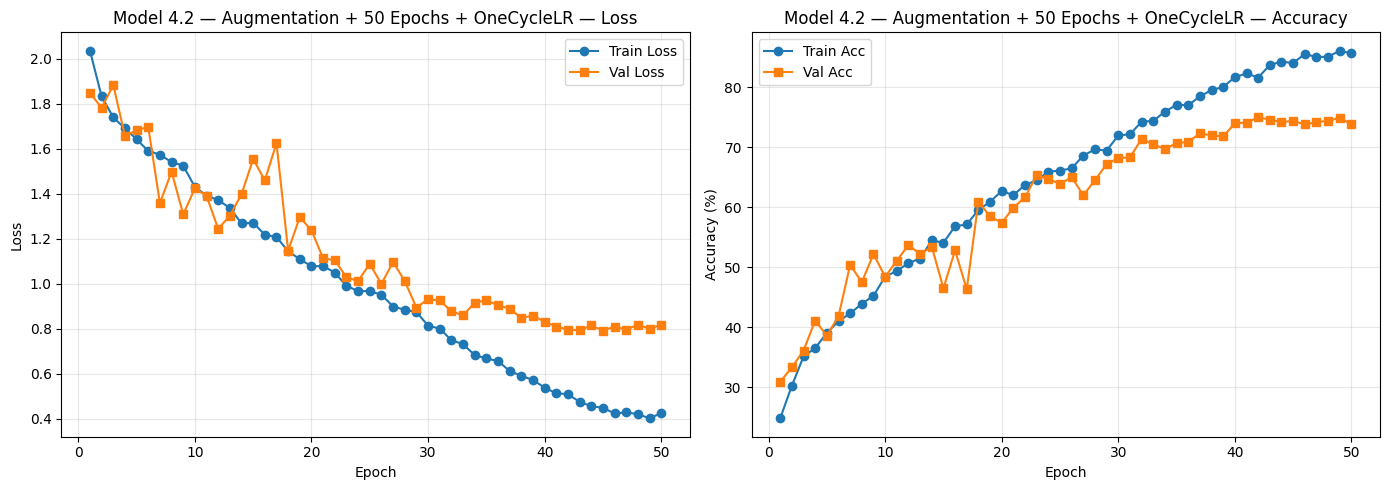

In [219]:
plot_history(history, title='Model 4.2 \u2014 Augmentation + 50 Epochs + OneCycleLR')

### 2.4 Results Summary

In [221]:
final_train_acc = history['train_acc'][-1]
final_val_acc   = history['val_acc'][-1]
peak_val_acc    = max(history['val_acc'])
gap             = final_train_acc - final_val_acc

print('=' * 65)
print('   MODEL 4.2 \u2014 RESULTS SUMMARY (Aug + 50 Epochs + OneCycleLR)')
print('=' * 65)
print(f'  Parameters       : {count_parameters(model):,}')
print(f'  Final Train Acc  : {final_train_acc:.2f}%')
print(f'  Final Val Acc    : {final_val_acc:.2f}%')
print(f'  Peak Val Acc     : {peak_val_acc:.2f}%')
print(f'  Train-Val Gap    : {gap:+.2f}%')
print(f'  Final Train Loss : {history["train_loss"][-1]:.4f}')
print(f'  Final Val Loss   : {history["val_loss"][-1]:.4f}')
print(f'  Diagnosis      : Healthy.')
print('=' * 65)

   MODEL 4.2 — RESULTS SUMMARY (Aug + 50 Epochs + OneCycleLR)
  Parameters       : 1,149,770
  Final Train Acc  : 85.64%
  Final Val Acc    : 73.80%
  Peak Val Acc     : 75.00%
  Train-Val Gap    : +11.84%
  Final Train Loss : 0.4245
  Final Val Loss   : 0.8169
  Diagnosis      : Healthy.
